# Phase 4: ML Data Preprocessing

**Objectives:**
1. Drop columns that cause data leakage
2. Train/Test split (80/20)
3. Build preprocessing pipelines
4. Fit on train, transform on test

**Data Leakage Prevention:**
- Drop `Route_Pair` (redundant with Source + Destination)
- Drop `Arrival_Hour`, `Arrival_Minute` (not known at booking time)
- Fit encoders/scalers ONLY on training data

## 4.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## 4.2 Load Cleaned Data

In [2]:
df = pd.read_csv('D:/Courses/DL INTERNSHIP/SECOND PROJECT/project_structure/data/processed/flight_data_cleaned.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (10363, 15)


,Airline,Source,Destination,Additional_Info,Price,Duration_Minutes,Stops,Journey_Day,Journey_Month,Journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Route_Pair
0,IndiGo,Banglore,New Delhi,No info,3897,170,0,24,3,6,22,20,1,10,Banglore_New Delhi
1,Air India,Kolkata,Banglore,No info,7662,445,2,1,5,2,5,50,13,15,Kolkata_Banglore
2,Jet Airways,Delhi,Cochin,No info,13882,1140,2,9,6,6,9,25,4,25,Delhi_Cochin
3,IndiGo,Kolkata,Banglore,No info,6218,325,1,12,5,6,18,5,23,30,Kolkata_Banglore
4,IndiGo,Banglore,New Delhi,No info,13302,285,1,1,3,4,16,50,21,35,Banglore_New Delhi


In [3]:
df.columns.tolist()

['Airline',
 'Source',
 'Destination',
 'Additional_Info',
 'Price',
 'Duration_Minutes',
 'Stops',
 'Journey_Day',
 'Journey_Month',
 'Journey_Day_of_Week',
 'Dep_Hour',
 'Dep_Minute',
 'Arrival_Hour',
 'Arrival_Minute',
 'Route_Pair']

## 4.3 Drop Leakage Columns

In [4]:
# Columns that cause data leakage or are redundant
leakage_columns = [
    'Route_Pair',      # Redundant - created from Source + Destination
    'Arrival_Hour',    # Not known at booking time
    'Arrival_Minute'   # Not known at booking time
]

print("Dropping columns:")
for col in leakage_columns:
    if col in df.columns:
        print(f"  - {col}")
        df.drop(col, axis=1, inplace=True)

print(f"\nShape after drop: {df.shape}")

Dropping columns:
  - Route_Pair
  - Arrival_Hour
  - Arrival_Minute

Shape after drop: (10363, 12)


In [5]:
df.columns.tolist()

['Airline',
 'Source',
 'Destination',
 'Additional_Info',
 'Price',
 'Duration_Minutes',
 'Stops',
 'Journey_Day',
 'Journey_Month',
 'Journey_Day_of_Week',
 'Dep_Hour',
 'Dep_Minute']

## 4.4 Define Features and Target

In [6]:
# Target variable
target = 'Price'

# Features
X = df.drop(target, axis=1)
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (10363, 11)
Target shape: (10363,)


In [7]:
# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

Categorical columns (4): ['Airline', 'Source', 'Destination', 'Additional_Info']
Numerical columns (7): ['Duration_Minutes', 'Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute']


## 4.5 Train/Test Split

In [8]:
# Split BEFORE any preprocessing (critical for preventing data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8290, 11)
X_test: (2073, 11)
y_train: (8290,)
y_test: (2073,)


In [9]:
# Verify split ratio
print(f"Train ratio: {len(X_train) / len(X) * 100:.1f}%")
print(f"Test ratio: {len(X_test) / len(X) * 100:.1f}%")

Train ratio: 80.0%
Test ratio: 20.0%


## 4.6 Check Target Distribution in Train/Test

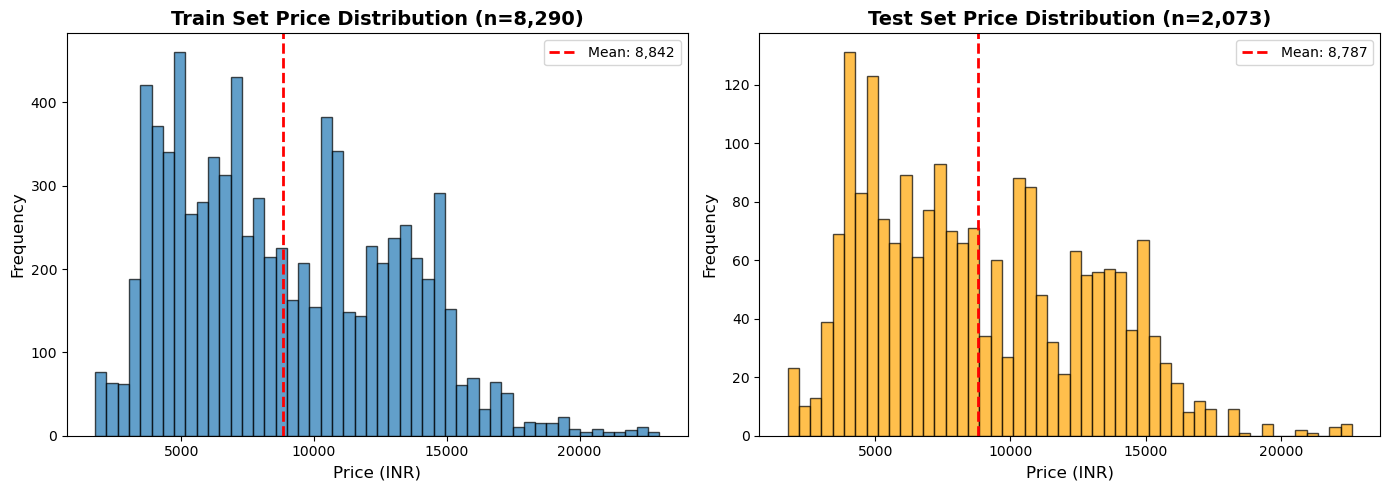

Train mean: 8,842.35, std: 4,077.78
Test mean: 8,786.90, std: 4,028.51


In [10]:
# Ensure similar distribution in train and test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_train.mean():,.0f}')
axes[0].set_title(f'Train Set Price Distribution (n={len(y_train):,})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price (INR)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()

axes[1].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_test.mean():,.0f}')
axes[1].set_title(f'Test Set Price Distribution (n={len(y_test):,})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (INR)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Train mean: {y_train.mean():,.2f}, std: {y_train.std():,.2f}")
print(f"Test mean: {y_test.mean():,.2f}, std: {y_test.std():,.2f}")

## 4.7 Build Preprocessing Pipeline

In [11]:
# Numerical columns to scale
# Only Duration_Minutes needs scaling (different magnitude)
# Other numerical columns (Stops, Day, Month, Hour, Minute) are already on similar scales

cols_to_scale = ['Duration_Minutes']
cols_passthrough = ['Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute']

print(f"Columns to scale: {cols_to_scale}")
print(f"Columns to passthrough: {cols_passthrough}")
print(f"Columns to encode: {categorical_cols}")

Columns to scale: ['Duration_Minutes']
Columns to passthrough: ['Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute']
Columns to encode: ['Airline', 'Source', 'Destination', 'Additional_Info']


In [12]:
# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), cols_to_scale),
        ('passthrough', 'passthrough', cols_passthrough),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

print("Preprocessor built successfully")

Preprocessor built successfully


## 4.8 Fit on Train, Transform Train & Test

In [13]:
# Fit ONLY on training data (critical!)
X_train_processed = preprocessor.fit_transform(X_train)

# Transform test data using fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

X_train_processed shape: (8290, 31)
X_test_processed shape: (2073, 31)


In [14]:
# Get feature names after transformation
def get_feature_names(preprocessor):
    feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'scale':
            feature_names.extend(columns)
        elif name == 'passthrough':
            feature_names.extend(columns)
        elif name == 'onehot':
            # Get OneHotEncoder feature names
            ohe = transformer
            for i, col in enumerate(columns):
                categories = ohe.categories_[i][1:]  # Skip first due to drop='first'
                for cat in categories:
                    feature_names.append(f"{col}_{cat}")
    
    return feature_names

feature_names = get_feature_names(preprocessor)
print(f"Total features after preprocessing: {len(feature_names)}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names, 1):
    print(f"  {i}. {name}")

Total features after preprocessing: 31

Feature names:
  1. Duration_Minutes
  2. Stops
  3. Journey_Day
  4. Journey_Month
  5. Journey_Day_of_Week
  6. Dep_Hour
  7. Dep_Minute
  8. Airline_Air India
  9. Airline_GoAir
  10. Airline_IndiGo
  11. Airline_Jet Airways
  12. Airline_Multiple carriers
  13. Airline_Multiple carriers Premium economy
  14. Airline_SpiceJet
  15. Airline_Trujet
  16. Airline_Vistara
  17. Airline_Vistara Premium economy
  18. Source_Chennai
  19. Source_Delhi
  20. Source_Kolkata
  21. Source_Mumbai
  22. Destination_Cochin
  23. Destination_Delhi
  24. Destination_Hyderabad
  25. Destination_Kolkata
  26. Destination_New Delhi
  27. Additional_Info_Change airports
  28. Additional_Info_In-flight meal not included
  29. Additional_Info_No check-in baggage included
  30. Additional_Info_No info
  31. Additional_Info_Red-eye flight


## 4.9 Convert to DataFrames (for inspection)

In [15]:
# Create DataFrames with feature names
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("X_train_df:")
X_train_df.head()

X_train_df:


,Duration_Minutes,Stops,Journey_Day,Journey_Month,Journey_Day_of_Week,Dep_Hour,Dep_Minute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,1.772951,2.0,12.0,3.0,1.0,8.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.297068,1.0,21.0,3.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.257626,2.0,9.0,6.0,6.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.148489,1.0,21.0,5.0,1.0,9.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.406205,1.0,3.0,3.0,6.0,13.0,55.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Verify scaling worked
print("Duration_Minutes after scaling:")
print(f"  Train - Mean: {X_train_df['Duration_Minutes'].mean():.4f}, Std: {X_train_df['Duration_Minutes'].std():.4f}")
print(f"  Test - Mean: {X_test_df['Duration_Minutes'].mean():.4f}, Std: {X_test_df['Duration_Minutes'].std():.4f}")

Duration_Minutes after scaling:
  Train - Mean: -0.0000, Std: 1.0001
  Test - Mean: -0.0133, Std: 0.9630


In [17]:
# Check for any NaN values
print(f"NaN in X_train_processed: {np.isnan(X_train_processed).sum()}")
print(f"NaN in X_test_processed: {np.isnan(X_test_processed).sum()}")

NaN in X_train_processed: 0
NaN in X_test_processed: 0


## 4.10 Verify Encoding

In [18]:
# Check one-hot encoded columns
encoded_cols = [col for col in feature_names if '_' in col and col not in ['Duration_Minutes', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute']]

print(f"One-hot encoded columns: {len(encoded_cols)}")
print("\nEncoded column groups:")

# Group by original column
for orig_col in categorical_cols:
    cols = [c for c in encoded_cols if c.startswith(orig_col + '_')]
    print(f"  {orig_col}: {len(cols)} categories")

One-hot encoded columns: 24

Encoded column groups:
  Airline: 10 categories
  Source: 4 categories
  Destination: 5 categories
  Additional_Info: 5 categories


## 4.11 Save Preprocessed Data & Preprocessor

In [19]:
import joblib

# Save preprocessor for later use (deployment)
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved to 'preprocessor.pkl'")

# Save feature names
joblib.dump(feature_names, 'feature_names.pkl')
print("Feature names saved to 'feature_names.pkl'")

Preprocessor saved to 'preprocessor.pkl'
Feature names saved to 'feature_names.pkl'


In [20]:
# Save processed data as numpy arrays
np.save('X_train_processed.npy', X_train_processed)
np.save('X_test_processed.npy', X_test_processed)
np.save('y_train.npy', y_train.values)
np.save('y_test.npy', y_test.values)

print("Processed data saved:")
print("  - X_train_processed.npy")
print("  - X_test_processed.npy")
print("  - y_train.npy")
print("  - y_test.npy")

Processed data saved:
  - X_train_processed.npy
  - X_test_processed.npy
  - y_train.npy
  - y_test.npy


## 4.12 Phase 4 Summary (Upload This Output)

In [ ]:
print("="*70)
print("PHASE 4: ML DATA PREPROCESSING SUMMARY")
print("="*70)

print("\n1. DATA LEAKAGE PREVENTION")
print("   Dropped columns:")
print("   - Route_Pair (redundant with Source + Destination)")
print("   - Arrival_Hour (not known at booking time)")
print("   - Arrival_Minute (not known at booking time)")

print("\n2. TRAIN/TEST SPLIT")
print(f"   Total samples: {len(X):,}")
print(f"   Train samples: {len(X_train):,} (80%)")
print(f"   Test samples: {len(X_test):,} (20%)")
print(f"   Random state: 42")

print("\n3. FEATURE ENGINEERING")
print(f"   Original features: {X.shape[1]}")
print(f"   After preprocessing: {X_train_processed.shape[1]}")

print("\n4. PREPROCESSING PIPELINE")
print(f"   Scaled (StandardScaler): {cols_to_scale}")
print(f"   Passthrough: {cols_passthrough}")
print(f"   OneHotEncoded: {categorical_cols}")

print("\n5. CATEGORICAL ENCODING DETAILS")
for orig_col in categorical_cols:
    cols = [c for c in feature_names if c.startswith(orig_col + '_')]
    print(f"   {orig_col}: {len(cols)+1} categories → {len(cols)} encoded (drop='first')")

print("\n6. FINAL SHAPES")
print(f"   X_train_processed: {X_train_processed.shape}")
print(f"   X_test_processed: {X_test_processed.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

print("\n7. TARGET DISTRIBUTION CHECK")
print(f"   Train - Mean: ₹{y_train.mean():,.0f}, Std: ₹{y_train.std():,.0f}")
print(f"   Test - Mean: ₹{y_test.mean():,.0f}, Std: ₹{y_test.std():,.0f}")

print("\n8. SAVED ARTIFACTS")
print("   - preprocessor.pkl")
print("   - feature_names.pkl")
print("   - X_train_processed.npy")
print("   - X_test_processed.npy")
print("   - y_train.npy")
print("   - y_test.npy")



PHASE 4: ML DATA PREPROCESSING SUMMARY

1. DATA LEAKAGE PREVENTION
   Dropped columns:
   - Route_Pair (redundant with Source + Destination)
   - Arrival_Hour (not known at booking time)
   - Arrival_Minute (not known at booking time)

2. TRAIN/TEST SPLIT
   Total samples: 10,363
   Train samples: 8,290 (80%)
   Test samples: 2,073 (20%)
   Random state: 42

3. FEATURE ENGINEERING
   Original features: 11
   After preprocessing: 31

4. PREPROCESSING PIPELINE
   Scaled (StandardScaler): ['Duration_Minutes']
   Passthrough: ['Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute']
   OneHotEncoded: ['Airline', 'Source', 'Destination', 'Additional_Info']

5. CATEGORICAL ENCODING DETAILS
   Airline: 11 categories → 10 encoded (drop='first')
   Source: 5 categories → 4 encoded (drop='first')
   Destination: 6 categories → 5 encoded (drop='first')
   Additional_Info: 6 categories → 5 encoded (drop='first')

6. FINAL SHAPES
   X_train_processed: (8290, 31)
   